 Goal is to predict UPDRS1-4 based on NPXand peptide abundance

# Importing Data & Libraries

In [138]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [139]:
pip install tensorflow_decision_forests


Note: you may need to restart the kernel to use updated packages.


In [140]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE

import tensorflow_decision_forests as tfdf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


In [141]:
#import data
proteins = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
peptides= pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
clinical= pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
supplemental= pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv")


# Viewing Data

In [142]:
#get shape
print(proteins.shape)
print(peptides.shape)
print(clinical.shape)

(232741, 5)
(981834, 6)
(2615, 8)


In [143]:
proteins.head()


,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


NPX(Normalized Protein eXpression): value of concentration for all the proteins relevant to Parkinson. Just note proteins are made of peptides.

In [144]:
peptides.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


Peptide Abundance: Abundance of each peptide in proteins relevant to parkinson. AKA: Concentration of peptides. NOT TO BE CONFUSED with peptide abundance.

In [145]:
clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


# Data Definitions

*  visit ID     is the ID code for the visit.
*  Visit_month  is the month of the visit, relative to the first visit by the patient.
*  Patient_id   is the specific ID code for the patient.
*  UniProt      is the UniProt ID code for the associated protein. Several peptides make a protein.
*  Peptide      is the sequence of amino acids included in the peptide.
*  NPX          is the normalized protein expression. The frequency of the protein's occurrence in the sample. 
*  updrs_[1-4]  is the patient's score for part N of the Unified Parkinson's Disease Rating Scale. Higher numbers indicate more severe symptoms. Each sub-section covers a distinct category of symptoms, such as mood and behavior for Part 1 and motor functions for Part 3.

* upd23b_clinical_state_on_medication  Whether or not the patient was taking medication such as Levodopa during the UPDRS assessment. Expected to mainly affect the scores for Part 3 (motor function). These medications wear off fairly quickly (on the order of one day) so it's common for patients to take the motor function exam twice in a single month, both with and without medication.

# Plotting Data

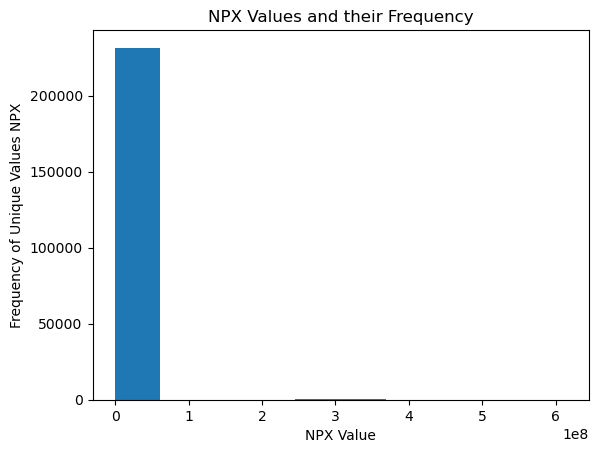

In [146]:
plt.hist(proteins["NPX"])
plt.xlabel("NPX Value") # what type of number appears
plt.ylabel("Frequency of Unique Values NPX")# how many times the number appears
plt.title("NPX Values and their Frequency")
plt.show()

Protein abundance has a skewed range.
Check out the unique values.


In [147]:
UniNPX =proteins["NPX"].unique()

print("max is", UniNPX.max())
print("min is" , UniNPX.min())
print( "mean is", UniNPX.mean())

max is 613851000.0
min is 84.6082
mean is 2856834.2224777536


This data has a wide range. Remebmer to scale your data later on!!!!!

/tmp/ipykernel_32/2475585168.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=filtered_proteins, x="visit_month", y="NPX", hue="UniProt", ci=None)


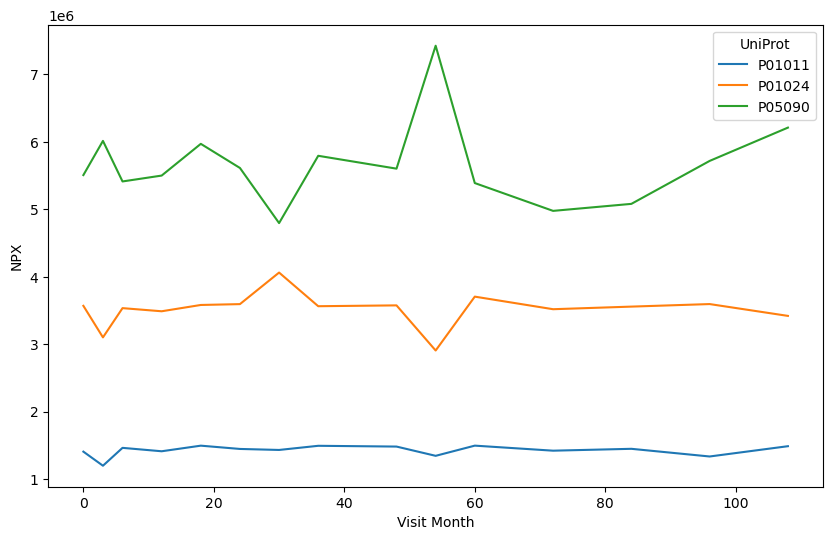

In [148]:
top_proteins = proteins['UniProt'].value_counts().head(3).index

# Filter the DataFrame to include only these top proteins
filtered_proteins = proteins[proteins['UniProt'].isin(top_proteins)]

# Create the line plot with hue set to 'UniProt' (protein)
plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_proteins, x="visit_month", y="NPX", hue="UniProt", ci=None)

# Set labels for the x and y axes
plt.xlabel("Visit Month")
plt.ylabel("NPX")

# Show the plot
plt.show()

Now lets view peptide abundance.

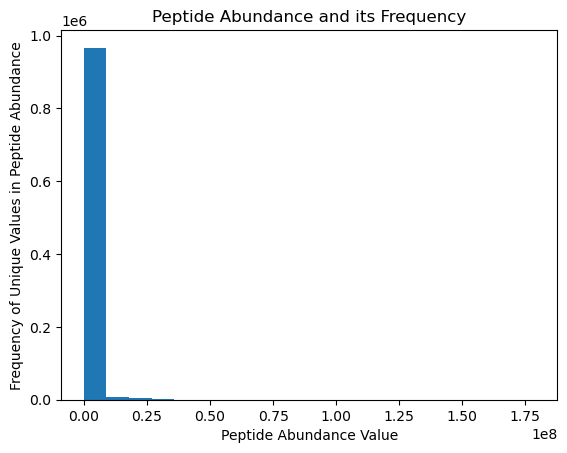

In [149]:
#percents of unique values of Peptide abundance

plt.hist(peptides["PeptideAbundance"], bins=20)
plt.xlabel("Peptide Abundance Value") # what type of number appears
plt.ylabel("Frequency of Unique Values in Peptide Abundance")# how many times the number appears
plt.title("Peptide Abundance and its Frequency")
plt.show()


Peptide abundance has a skewed range.
Check out the unique values.


In [150]:
pep_unique=pd.DataFrame(peptides["PeptideAbundance"].unique())
pep_unique.head()
print("Min is:", pep_unique.min())
print("Max is:", pep_unique.max())
print("Mean is:", pep_unique.mean())

Min is: 0    10.9985
dtype: float64
Max is: 0    178752000.0
dtype: float64
Mean is: 0    798078.241981
dtype: float64


Zoom In on The graph

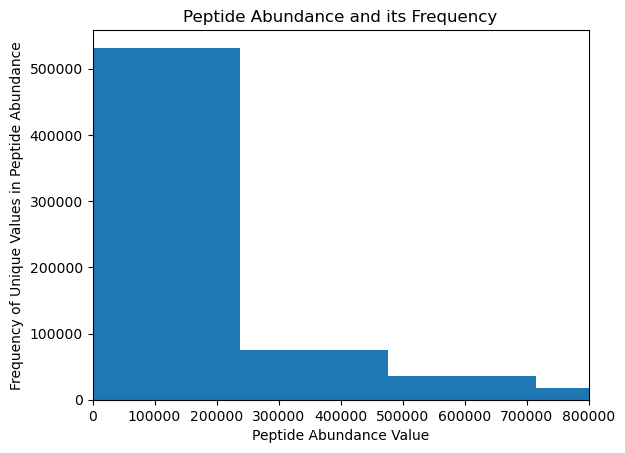

In [151]:
plt.hist(pep_unique, bins= 750)
plt.xlabel("Peptide Abundance Value") # what type of number appears
plt.ylabel("Frequency of Unique Values in Peptide Abundance")# how many times the number appears
plt.title("Peptide Abundance and its Frequency")
plt.xlim(-0, 800000)
plt.show()

This data has a wide range. Remebmer to scale your data later on!!!!!
But lets note that most peptides have a  concentration in the 100000s

/tmp/ipykernel_32/1769002035.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=peptides_filtered, x='visit_month', y='PeptideAbundance', hue='Peptide', ci=None, markers=True, palette='tab10')


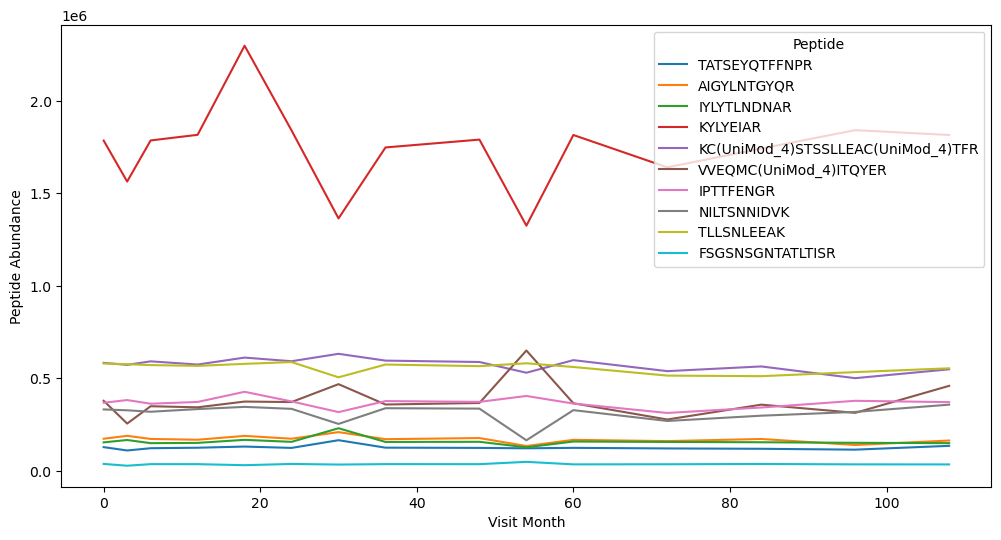

In [152]:
#Peptides Vs time
# Find the top 5 most common peptides
top_peptides = peptides['Peptide'].value_counts().nlargest(10).index

# Filter the DataFrame to include only data for the top 5 peptides
peptides_filtered = peptides[peptides['Peptide'].isin(top_peptides)]

# Create the line plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=peptides_filtered, x='visit_month', y='PeptideAbundance', hue='Peptide', ci=None, markers=True, palette='tab10')

# Set labels for the x and y axes
plt.xlabel('Visit Month')
plt.ylabel('Peptide Abundance')

# Show the legend
plt.legend(title='Peptide', loc='upper right')

# Show the plot
plt.show()

Viewing UPRDS for patient 1517 

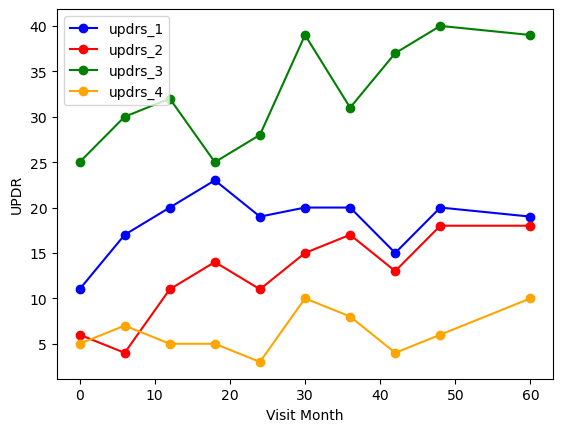

In [153]:
# Fetch data for patient with id 1517
plot_df = clinical[clinical["patient_id"]==1517]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="blue", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="red", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="green", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="orange", label="updrs_4", linestyle="-")
ax.set_xlabel("Visit Month")
ax.set_ylabel("UPDR")
ax.legend()
plt.show()

In [154]:
# Filter the DataFrame to select rows with non-NA values in updrs columns
# and where medication is "Off"
filtered_df = clinical[(~clinical["updrs_1"].isna()) & 
                 (~clinical["updrs_2"].isna()) & 
                 (~clinical["updrs_3"].isna()) & 
                 (~clinical["updrs_4"].isna()) & 
                 (clinical["upd23b_clinical_state_on_medication"] == "Off")]

# Print the filtered DataFrame
print(filtered_df)

      visit_id  patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4  \
25      942_72         942           72      4.0      2.0     33.0      0.0   
26      942_84         942           84      4.0      8.0     26.0      0.0   
27      942_96         942           96      6.0      9.0     39.0      3.0   
33     1517_30        1517           30     20.0     15.0     39.0     10.0   
36     1517_48        1517           48     20.0     18.0     40.0      6.0   
...        ...         ...          ...      ...      ...      ...      ...   
2610  65043_48       65043           48      7.0      6.0     13.0      0.0   
2611  65043_54       65043           54      4.0      8.0     11.0      1.0   
2612  65043_60       65043           60      6.0      6.0     16.0      1.0   
2613  65043_72       65043           72      3.0      9.0     14.0      1.0   
2614  65043_84       65043           84      7.0      9.0     20.0      3.0   

     upd23b_clinical_state_on_medication  
25      

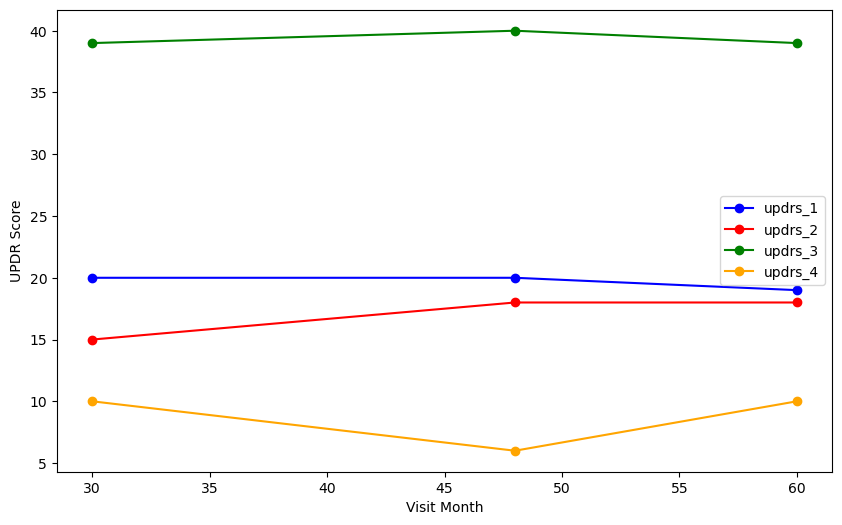

In [155]:
plot_df = filtered_df[filtered_df["patient_id"] == 1517]

# Create a figure and axis for the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot the UPDR scores for each UPDR type with different colors and markers
ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="blue", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="red", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="green", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="orange", label="updrs_4", linestyle="-")

# Set labels for the x and y axes, and add a legend
ax.set_xlabel("Visit Month")
ax.set_ylabel("UPDR Score")
ax.legend()

# Show the plot
plt.show()

This shows the filtered UPDRs values without the Na values and the effects of medication

Preparing a correlation heat map

In [156]:
df_heat= pd.DataFrame({"Visit_Month": proteins["visit_month"], "updrs-1":clinical["updrs_1"],"updrs-2":clinical["updrs_2"],"updrs-3":clinical["updrs_3"],"updrs-4":clinical["updrs_4"],"Protein Abund.":proteins["NPX"],"Peptide Abund.": peptides["PeptideAbundance"]})

In [157]:
corr= df_heat.corr()

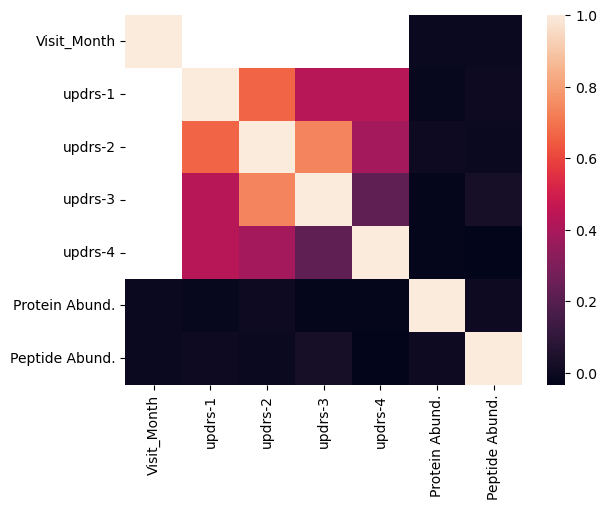

In [158]:
sns.heatmap(corr)
plt.show()

Cant Conclude much; However, unexpectedly theres no correlation among the values of interest.


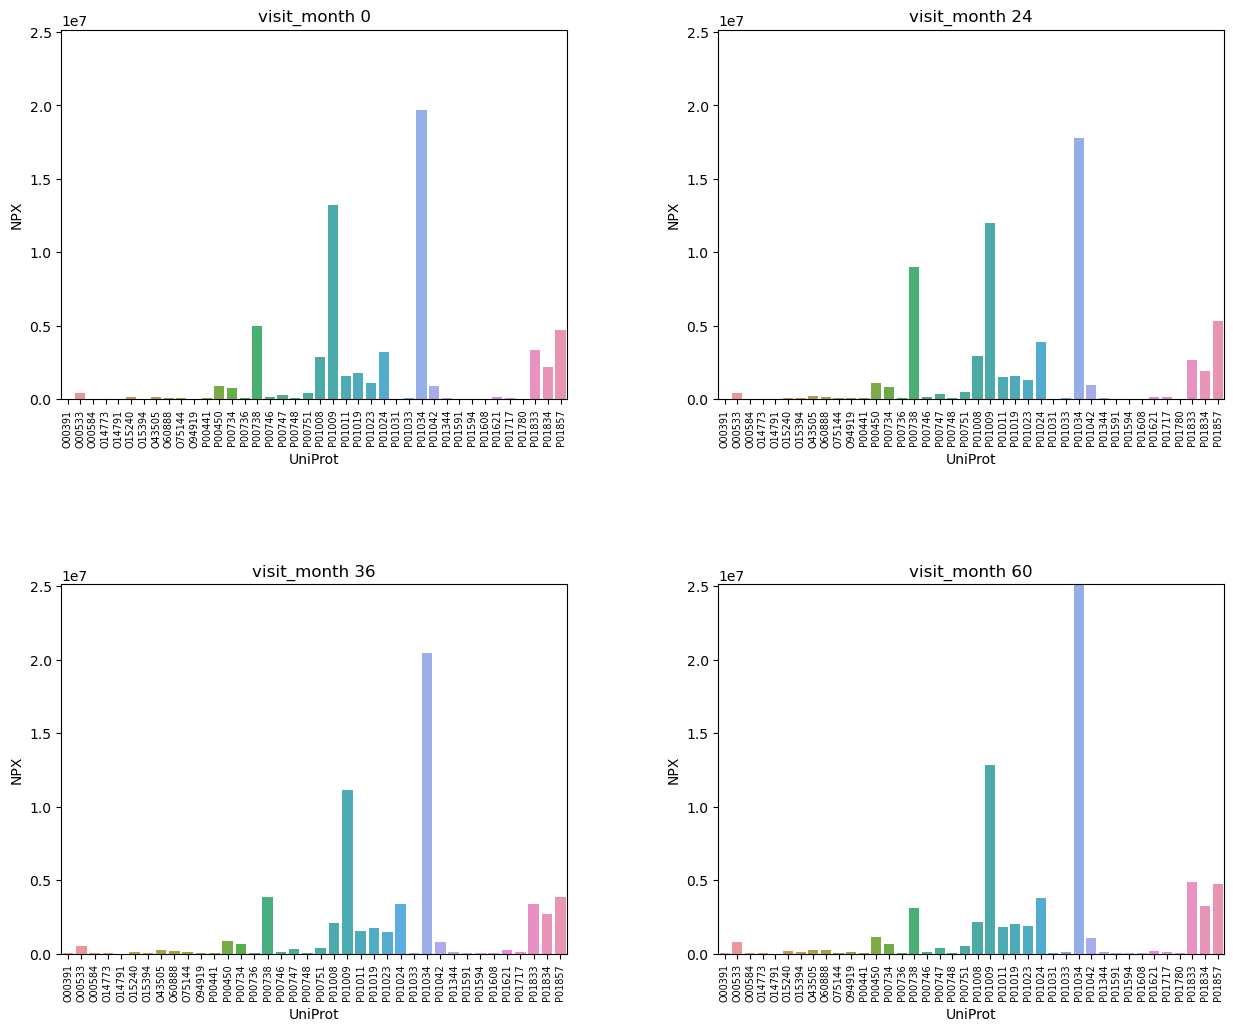

In [159]:
pro_plot_df = proteins[proteins["patient_id"] == 1517]
protein_list = pro_plot_df['UniProt'].unique()
protein_list = protein_list[:40]
pro_plot_df = pro_plot_df[pro_plot_df['UniProt'].isin(protein_list)]
unique_month = pro_plot_df['visit_month'].unique()
unique_month.sort()
p_len = len(unique_month)

pro_plot_df['visit_month'].unique()
n_rows = math.ceil(p_len / 2)
figure, axis = plt.subplots(n_rows, 2, figsize=(15, n_rows * 6))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Find the maximum NPX value across all graphs
max_npx = pro_plot_df['NPX'].max()

for i, month in enumerate(unique_month):
    row = i // 2
    col = i % 2
    plot_df = pro_plot_df[pro_plot_df['visit_month'] == month]
    bp = sns.barplot(ax=axis[row, col], x=plot_df['UniProt'], y=plot_df['NPX'])
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size=7)
    axis[row, col].set_title('visit_month ' + str(month))
    axis[row, col].set_ylim(0, max_npx)  # Set y-axis limit to the maximum NPX value
plt.show()

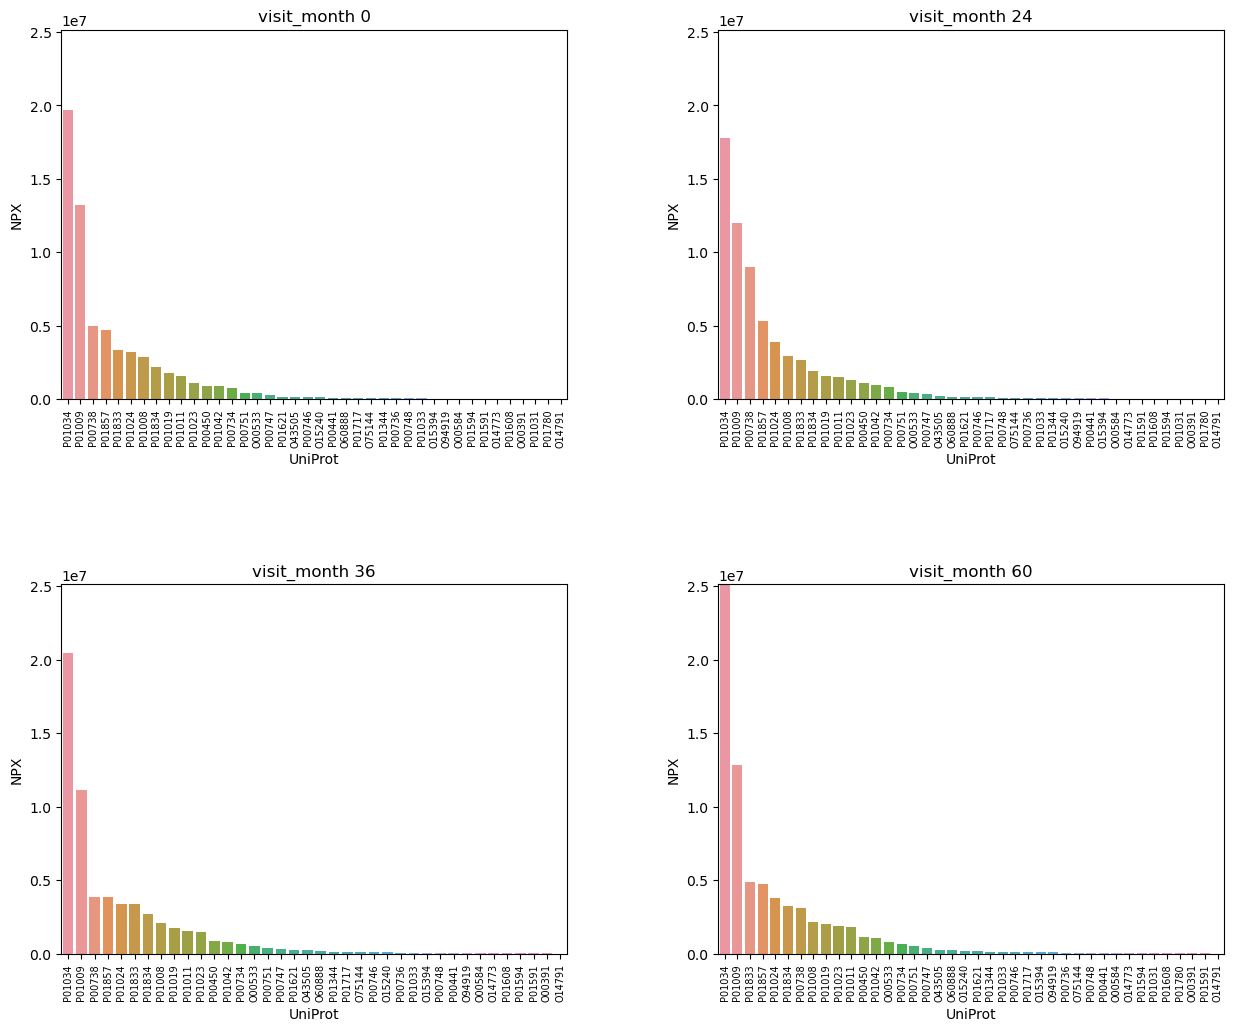

In [160]:
pro_plot_df = proteins[proteins["patient_id"] == 1517]
protein_list = pro_plot_df['UniProt'].unique()
protein_list = protein_list[:40]
pro_plot_df = pro_plot_df[pro_plot_df['UniProt'].isin(protein_list)]
unique_month = pro_plot_df['visit_month'].unique()
unique_month.sort()
p_len = len(unique_month)

pro_plot_df['visit_month'].unique()
n_rows = math.ceil(p_len / 2)
figure, axis = plt.subplots(n_rows, 2, figsize=(15, n_rows * 6))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Find the maximum NPX value across all data
max_npx = pro_plot_df['NPX'].max()

for i, month in enumerate(unique_month):
    row = i // 2
    col = i % 2
    plot_df = pro_plot_df[pro_plot_df['visit_month'] == month]
    
    # Sort plot_df by NPX value in descending order
    plot_df = plot_df.sort_values(by='NPX', ascending=False)
    
    bp = sns.barplot(ax=axis[row, col], x=plot_df['UniProt'], y=plot_df['NPX'])
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size=7)
    axis[row, col].set_title('visit_month ' + str(month))
    
    # Set the same y-axis limit for all subplots
    axis[row, col].set_ylim(0, max_npx)  # Adjust the limit as needed
    
plt.show()

# Preparing Data

#proteins
1. group by visit ID
2. group by protein ID
3. replace NPX in a group with NPX mean

#peptides
1. group by visit ID
2. group by peptide ids
3. replace peptide abundance values with mean of the peptideabundance values of all rows in that group

Obtaining labels for UPDRS1,2,3,4
  

Need to pivot data to get Visit ID as Index, and protein ID as columns.
Same for peptides.

In [161]:
# Function to prepare dataset with all the steps mentioned above:
def prepare_dataset(train_proteins, train_peptides):
    # Step 1: Grouping 
    df_protein_grouped = proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
    df_peptide_grouped = peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()
    
    # Step 2: Pivoting
    df_protein = df_protein_grouped.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
    df_peptide = df_peptide_grouped.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()
    
    # Step 3: Merging
    pro_pep_df = df_protein.merge(df_peptide, on = ['visit_id'], how = 'left')
    
    return pro_pep_df
    

In [162]:
pro_pep_df = prepare_dataset(proteins,peptides)

In [163]:
pro_pep_df.shape

(1113, 1196)

In [164]:
pro_pep_df.head(3)

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.3
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.8
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.7


In [165]:
pro_pep_df.describe()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
count,764.000000,1.112000e+03,1100.000000,1032.000000,1047.000000,942.000000,1113.000000,1050.000000,1110.000000,1079.000000,...,1100.000000,994.000000,1.022000e+03,977.000000,1.091000e+03,1111.000000,1089.000000,1105.000000,1030.000000,865.00000
mean,11641.264435,5.111649e+05,26505.529157,27305.934884,17688.295406,3004.990691,126151.780054,50773.474638,195599.363694,145382.047368,...,215246.833636,9015.134433,3.937256e+06,67866.452927,6.110779e+05,92581.223041,125937.993436,471554.596652,47068.709311,21072.04823
std,2817.003530,2.357357e+05,10705.152540,8446.187506,7166.325369,1142.159575,72748.393517,21382.028764,79739.704279,58028.089713,...,50727.227704,3127.061637,1.677710e+06,61176.002825,5.047422e+05,30138.957433,38696.448657,131150.715245,13689.667117,10360.59380
min,873.778000,5.971820e+04,591.103000,8945.340000,2811.120000,336.517000,10717.400000,5806.840000,29740.900000,8358.080000,...,12164.300000,258.249000,1.624640e+05,884.260000,7.494660e+03,869.898000,991.452000,11371.200000,6362.490000,868.90300
25%,9736.857500,3.490590e+05,19941.075000,21123.650000,12920.050000,2189.087500,70560.600000,37008.975000,142054.500000,103983.000000,...,186658.250000,6899.805000,2.895622e+06,30997.900000,2.929505e+05,70508.150000,100691.000000,384902.000000,37752.375000,14249.90000
50%,11546.400000,4.834425e+05,26529.700000,26624.000000,17399.600000,2865.460000,116900.000000,50375.800000,185616.000000,136452.000000,...,217430.500000,8604.345000,3.671010e+06,52576.900000,4.702450e+05,88918.600000,123588.000000,463382.000000,45503.150000,20390.90000
75%,13383.025000,6.485572e+05,33222.800000,32459.275000,22077.050000,3593.147500,164947.000000,63446.700000,239731.500000,177451.000000,...,246423.500000,10612.775000,4.710635e+06,85369.600000,7.592380e+05,110140.000000,149597.000000,549455.000000,54748.350000,27031.90000
max,21361.800000,1.806980e+06,66252.400000,65347.900000,49695.600000,9352.640000,538862.000000,137369.000000,766591.000000,427084.000000,...,409939.000000,27670.500000,1.385550e+07,712856.000000,3.984710e+06,251526.000000,264224.000000,948416.000000,107220.000000,70020.80000


Selecting  Models to Test:

* Random Forests
* GBM

# Preparing Labels, Cleaning Data, & Modeling With Random Forest

In [166]:
# Creating Features List
FEATURES = [i for i in pro_pep_df.columns if i not in ["visit_id"]]
FEATURES.append("visit_month")
print(FEATURES)

['O00391', 'O00533', 'O00584', 'O14498', 'O14773', 'O14791', 'O15240', 'O15394', 'O43505', 'O60888', 'O75144', 'O75326', 'O94919', 'P00441', 'P00450', 'P00734', 'P00736', 'P00738', 'P00746', 'P00747', 'P00748', 'P00751', 'P01008', 'P01009', 'P01011', 'P01019', 'P01023', 'P01024', 'P01031', 'P01033', 'P01034', 'P01042', 'P01344', 'P01591', 'P01594', 'P01608', 'P01621', 'P01717', 'P01780', 'P01833', 'P01834', 'P01857', 'P01859', 'P01860', 'P01861', 'P01876', 'P01877', 'P02452', 'P02647', 'P02649', 'P02652', 'P02655', 'P02656', 'P02671', 'P02675', 'P02679', 'P02747', 'P02748', 'P02749', 'P02750', 'P02751', 'P02753', 'P02760', 'P02763', 'P02765', 'P02766', 'P02768', 'P02774', 'P02787', 'P02790', 'P02792', 'P04004', 'P04075', 'P04156', 'P04180', 'P04196', 'P04207', 'P04211', 'P04216', 'P04217', 'P04275', 'P04406', 'P04433', 'P05060', 'P05067', 'P05090', 'P05155', 'P05156', 'P05408', 'P05452', 'P05546', 'P06310', 'P06396', 'P06454', 'P06681', 'P06727', 'P07195', 'P07225', 'P07333', 'P07339',

In [167]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

Smape Function: to check data

In [168]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# Model 1: Random Forest with Standard Scaler 

Create a loop to :

Part1
1. Define a Function to Split Data 
2. merge
3. drop null values
4. Scale data

Part 2

4. split and train the data set
5. Convert the dataset pandas-> tensorflow for faster processing

Initiating Empty list

In [61]:
model_dict = {}

# Create an empty dictionary to store the mse score of the models trained for each label.
mse_dict = {}

# Create an empty dictionary to store the sMAPE scores of the models trained for each label.
smape_dict = {}

In [180]:
 scaler = StandardScaler()

# List of target labels to loop through and train models
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

# Loop through each label
for label in target:
    
    # Merge the label 'visit_id', 'patient_id', 'visit_month' and label columns from `train_clinical` 
    # data frame to `pro_prep_df` data frame on the `visit_id` column.
    dataset_df = pro_pep_df.merge(clinical[['visit_id', 'patient_id', 'visit_month', label]], on=['visit_id'], how='left')
    
    # Drop null value label rows
    dataset_df = dataset_df.dropna(subset=[label])
    
    # Make a new copy of the FEATURES list we created previously. Add `label` to it.
    feature_list = FEATURES.copy()
    feature_list.append(label)
    
    # Scale the features in the Pandas DataFrame
    train_scaled = scaler.fit_transform(dataset_df[feature_list].values)
    
    
    
    # Convert the scaled DataFrame back to a Pandas DataFrame
    train_scaled_df = pd.DataFrame(train_scaled, columns=feature_list)
    
    
    # Split the dataset into train and validation datasets.
    train_df, valid_df = split_dataset(train_scaled_df)
    print("{} examples in training, {} examples in testing.".format(len(train_df), len(valid_df)))
    
    # Convert the Pandas DataFrame to TensorFlow datasets
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label, task=tfdf.keras.Task.REGRESSION)
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label, task=tfdf.keras.Task.REGRESSION)
    
    # Create and train the Random Forest model
    rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, verbose=0)
    rf.compile(metrics=["mse"])
    rf.fit(x=train_ds)
    
    # Store the trained model
    model_dict[label] = rf
    
    # Evaluate the trained model on the validation dataset and store the 
    # mse value in the `mse_dict`.
    inspector = rf.make_inspector()
    inspector.evaluation()
    evaluation = rf.evaluate(x=valid_ds, return_dict=True)
    mse_dict[label] = evaluation["mse"]  
    
    # Use the trained model to make predictions on the validation dataset.
    # Using these predictions, calculate and store the sMAPE value for this model.
    preds = rf.predict(valid_ds)
    smape_dict[label] = smape(valid_df[label].values.tolist(), preds.flatten())
    
    
    
    

/tmp/ipykernel_32/3365258163.py:30: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  train_scaled_df = train_scaled_df.merge(clinical[['visit_month', 'visit_id']], on='visit_month', how='left')


850 examples in training, 218 examples in testing.


[INFO 23-09-23 04:08:20.2798 UTC kernel.cc:1242] Loading model from path /tmp/tmplyq8q701/model/ with prefix c4889d19990c400e
[INFO 23-09-23 04:08:20.5444 UTC decision_forest.cc:660] Model loaded with 300 root(s), 68946 node(s), and 1196 input feature(s).
[INFO 23-09-23 04:08:20.5448 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-23 04:08:20.5456 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 2s 2s/step
856 examples in training, 212 examples in testing.


/tmp/ipykernel_32/3365258163.py:30: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  train_scaled_df = train_scaled_df.merge(clinical[['visit_month', 'visit_id']], on='visit_month', how='left')
[INFO 23-09-23 04:09:29.1001 UTC kernel.cc:1242] Loading model from path /tmp/tmpzpd2sq10/model/ with prefix c07013a1474f4335
[INFO 23-09-23 04:09:29.3592 UTC decision_forest.cc:660] Model loaded with 300 root(s), 66898 node(s), and 1196 input feature(s).
[INFO 23-09-23 04:09:29.3594 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-23 04:09:29.3601 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 2s 2s/step
831 examples in training, 227 examples in testing.


/tmp/ipykernel_32/3365258163.py:30: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  train_scaled_df = train_scaled_df.merge(clinical[['visit_month', 'visit_id']], on='visit_month', how='left')
[INFO 23-09-23 04:10:31.3853 UTC kernel.cc:1242] Loading model from path /tmp/tmpxr6i064r/model/ with prefix b1e44433560247cf
[INFO 23-09-23 04:10:31.6639 UTC decision_forest.cc:660] Model loaded with 300 root(s), 72104 node(s), and 1196 input feature(s).
[INFO 23-09-23 04:10:31.6642 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-23 04:10:31.6654 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 2s 2s/step
462 examples in training, 107 examples in testing.


/tmp/ipykernel_32/3365258163.py:30: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  train_scaled_df = train_scaled_df.merge(clinical[['visit_month', 'visit_id']], on='visit_month', how='left')
[INFO 23-09-23 04:11:22.8356 UTC kernel.cc:1242] Loading model from path /tmp/tmpwf57kcxp/model/ with prefix 40ed95ec168645b4
[INFO 23-09-23 04:11:22.9332 UTC decision_forest.cc:660] Model loaded with 300 root(s), 24552 node(s), and 1194 input feature(s).
[INFO 23-09-23 04:11:22.9334 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-23 04:11:22.9344 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 2s 2s/step


In [198]:
model_metrics_df1 = pd.DataFrame({
    'Label': target,
    'MSE': [mse_dict[label] for label in target],
    'SMAPE': [smape_dict[label] for label in target]})

# Save the model metrics as a CSV file
model_metrics_df1.to_csv('model_metrics1.csv', index=False)

Now lets try with robust scaler with model 2

# Verifying Model 1

MSE

In [105]:
for name, value in mse_dict.items():
  print(f"label {name}: mse {value:.4f}")

print("\nAverage mse", sum(mse_dict.values())/4)

label updrs_1: mse 0.7809
label updrs_2: mse 0.7814
label updrs_3: mse 0.9000
label updrs_4: mse 1.1004

Average mse 0.8906794935464859


sMAPE

In [64]:
for name, value in smape_dict.items():
  print(f"label {name}: sMAPE {value:.4f}")

print("\nAverage sMAPE", sum(smape_dict.values())/4)

label updrs_1: sMAPE 143.0184
label updrs_2: sMAPE 139.4687
label updrs_3: sMAPE 136.1677
label updrs_4: sMAPE 160.8611

Average sMAPE 144.87895589596306


# Model 2: Random Forest Regression with Robust Scaler

Used a robust scale instead of a standard scaler!Because my data is not originally normaly distributed.

In [65]:
#empty lists 2
model_dict2 = {}

# Create an empty dictionary to store the mse score of the models trained for each label.
mse_dict2 = {}

# Create an empty dictionary to store the sMAPE scores of the models trained for each label.
smape_dict2 = {}

In [188]:
scaler = RobustScaler()

# List of target labels to loop through and train models
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

# Loop through each label
for label in target:
    
    # Merge the label 'visit_id', 'patient_id', 'visit_month' and label columns from `train_clinical` 
    # data frame to `pro_prep_df` data frame on the `visit_id` column.
    dataset_df = pro_pep_df.merge(clinical[['visit_id', 'patient_id', 'visit_month', label]], on=['visit_id'], how='left')
    
    # Drop null value label rows
    dataset_df = dataset_df.dropna(subset=[label])
    
    # Make a new copy of the FEATURES list we created previously. Add `label` to it.
    feature_list = FEATURES.copy()
    feature_list.append(label)
    
    # Scale the features in the Pandas DataFrame using RobustScaler
    train_scaled = scaler.fit_transform(dataset_df[feature_list].values)
    
    # Convert the scaled DataFrame back to a Pandas DataFrame
    train_scaled_df = pd.DataFrame(train_scaled, columns=feature_list)
    
    # Split the dataset into train and validation datasets.
    train_df, valid_df = split_dataset(train_scaled_df)
    print("{} examples in training, {} examples in testing.".format(len(train_df), len(valid_df)))
    
    # Convert the Pandas DataFrame to TensorFlow datasets
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label, task=tfdf.keras.Task.REGRESSION)
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label, task=tfdf.keras.Task.REGRESSION)
    
    # Create and train the Random Forest model
    rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, verbose=0)
    rf.compile(metrics=["mse"])
    rf.fit(x=train_ds)
    
    # Store the trained model
    model_dict2[label] = rf
    
    # Evaluate the trained model on the validation dataset and store the 
    # mse value in the `mse_dict`.
    inspector = rf.make_inspector()
    inspector.evaluation()
    evaluation = rf.evaluate(x=valid_ds, return_dict=True)
    mse_dict2[label] = evaluation["mse"]  
    
    # Use the trained model to make predictions on the validation dataset.
    # Using these predictions, calculate and store the sMAPE value for this model.
    preds = rf.predict(valid_ds)
    smape_dict2[label] = smape(valid_df[label].values.tolist(), preds.flatten())
    
  

833 examples in training, 235 examples in testing.


[INFO 23-09-23 04:26:03.4484 UTC kernel.cc:1242] Loading model from path /tmp/tmpbddcxadg/model/ with prefix 69991949b6814813
[INFO 23-09-23 04:26:03.7163 UTC decision_forest.cc:660] Model loaded with 300 root(s), 68248 node(s), and 1196 input feature(s).
[INFO 23-09-23 04:26:03.7165 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-23 04:26:03.7175 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 2s 2s/step
871 examples in training, 197 examples in testing.


[INFO 23-09-23 04:27:12.7512 UTC kernel.cc:1242] Loading model from path /tmp/tmp0j1fz6b3/model/ with prefix 39b1a839c6194e45
[INFO 23-09-23 04:27:13.0321 UTC decision_forest.cc:660] Model loaded with 300 root(s), 68278 node(s), and 1196 input feature(s).
[INFO 23-09-23 04:27:13.0323 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-23 04:27:13.0331 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 2s 2s/step
836 examples in training, 222 examples in testing.


[INFO 23-09-23 04:28:14.4235 UTC kernel.cc:1242] Loading model from path /tmp/tmpbsqee3rf/model/ with prefix d1314a2b7acb4492
[INFO 23-09-23 04:28:14.7176 UTC decision_forest.cc:660] Model loaded with 300 root(s), 72324 node(s), and 1196 input feature(s).
[INFO 23-09-23 04:28:14.7178 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-23 04:28:14.7187 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 2s 2s/step
457 examples in training, 112 examples in testing.


[INFO 23-09-23 04:29:05.7774 UTC kernel.cc:1242] Loading model from path /tmp/tmp93lewve5/model/ with prefix 212fe1d2ae1443d0
[INFO 23-09-23 04:29:05.8722 UTC decision_forest.cc:660] Model loaded with 300 root(s), 24384 node(s), and 1193 input feature(s).
[INFO 23-09-23 04:29:05.8725 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-23 04:29:05.8734 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 2s 2s/step


# Verifying # Model 2: Random Forest Regression with Robust Scaler
sMAPE &MSE


MSE model2



In [189]:
for name, value in mse_dict2.items():
  print(f"label {name}: mse {value:.4f}")

print("\nAverage mse", sum(mse_dict2.values())/4)

label updrs_1: mse 0.5712
label updrs_2: mse 0.4215
label updrs_3: mse 0.2593
label updrs_4: mse 1.1945

Average mse 0.61160559207201


sMAPE model2

In [190]:
for name, value in smape_dict2.items():
  print(f"label {name}: sMAPE {value:.4f}")

print("\nAverage sMAPE", sum(smape_dict2.values())/4)

label updrs_1: sMAPE 139.5744
label updrs_2: sMAPE 138.9512
label updrs_3: sMAPE 136.3823
label updrs_4: sMAPE 147.5631

Average sMAPE 140.6177486009252


In [197]:
model_metrics_df2 = pd.DataFrame({
    'Label': target,
    'MSE': [mse_dict2[label] for label in target],
    'SMAPE': [smape_dict2[label] for label in target]})

# Save the model metrics as a CSV file
model_metrics_df2.to_csv('model_metrics2.csv', index=False)

# Model 3: GBM Without Robust Scaler

In [192]:
#Initiate Empty Lists
#empty lists 3
model_dict3 = {}

# Create an empty dictionary to store the mse score of the models trained for each label.
mse_dict3 = {}

# Create an empty dictionary to store the sMAPE scores of the models trained for each label.
smape_dict3 = {}

In [193]:
#Model
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]


# Loop through each label
for label in target:
    
    # Merge the label 'visit_id', 'patient_id', 'visit_month' and label columns from `train_clinical` 
    # data frame to `pro_prep_df` data frame on the `visit_id` column.
    dataset_df = pro_pep_df.merge(clinical[['visit_id', 'patient_id', 'visit_month', label]], on=['visit_id'], how='left')
    
    # Drop null value label rows
    dataset_df = dataset_df.dropna(subset=[label])
    
    # Make a new copy of the FEATURES list we created previously. Add `label` to it.
    feature_list = FEATURES.copy()
    feature_list.append(label)
    
    # Split the dataset into train and validation datasets.
    train_df, valid_df = split_dataset(dataset_df[feature_list])
    print("{} examples in training, {} examples in testing.".format(len(train_df), len(valid_df)))
    
    # Convert the Pandas DataFrame to TensorFlow datasets
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label, task=tfdf.keras.Task.REGRESSION)
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label, task=tfdf.keras.Task.REGRESSION)
    
    # Create and train the Gradient Boosted Trees (GBT) model
    gbt = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION, verbose=0)
    gbt.compile(metrics=["mse"])
    gbt.fit(x=train_ds)
    
    # Store the trained model
    model_dict3[label] = gbt
    
    # Evaluate the trained model on the validation dataset and store the 
    # mse value in the `mse_dict`.
    inspector = gbt.make_inspector()
    inspector.evaluation()
    evaluation = gbt.evaluate(x=valid_ds, return_dict=True)
    mse_dict3[label] = evaluation["mse"]  
    
    # Use the trained model to make predictions on the validation dataset.
    # Using these predictions, calculate and store the sMAPE value for this model.
    preds = gbt.predict(valid_ds)
    smape_dict3[label] = smape(valid_df[label].values.tolist(), preds.flatten())
    


853 examples in training, 215 examples in testing.


[WARNING 23-09-23 04:30:27.3113 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-23 04:30:27.3113 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-23 04:30:27.3113 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-09-23 04:31:27.3073 UTC kernel.cc:1242] Loading model from path /tmp/tmpt7a0icym/model/ with prefix b20e722f87c84479
[INFO 23-09-23 04:31:27.3234 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-09-23 04:31:27.3244 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 2s 2s/step
839 examples in training, 229 examples in testing.


[WARNING 23-09-23 04:31:47.1553 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-23 04:31:47.1554 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-23 04:31:47.1554 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-09-23 04:33:47.5442 UTC kernel.cc:1242] Loading model from path /tmp/tmp7v440twm/model/ with prefix 3eb8e11dd9124bb4
[INFO 23-09-23 04:33:47.5928 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-09-23 04:33:47.5939 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 12s 12s/step
847 examples in training, 211 examples in testing.


[WARNING 23-09-23 04:34:17.0698 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-23 04:34:17.0698 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-23 04:34:17.0698 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-09-23 04:35:27.7922 UTC kernel.cc:1242] Loading model from path /tmp/tmp10pctn18/model/ with prefix 7660700db53b4527
[INFO 23-09-23 04:35:27.8161 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-09-23 04:35:27.8171 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 2s 2s/step
443 examples in training, 126 examples in testing.


[WARNING 23-09-23 04:35:48.4970 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-23 04:35:48.4970 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-23 04:35:48.4971 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-09-23 04:36:17.1994 UTC kernel.cc:1242] Loading model from path /tmp/tmpi53z0ysa/model/ with prefix a04dfbb4fbf546e5
[INFO 23-09-23 04:36:17.2023 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-09-23 04:36:17.2028 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 2s 2s/step


# Verifying Model 3

MSE for model 3

In [194]:
for name, value in mse_dict3.items():
  print(f"label {name}: mse {value:.4f}")

print("\nAverage mse", sum(mse_dict3.values())/4)

label updrs_1: mse 24.4994
label updrs_2: mse 26.0192
label updrs_3: mse 143.5099
label updrs_4: mse 7.5670

Average mse 50.39886546134949


sMAPE for model 3

In [195]:
for name, value in smape_dict3.items():
  print(f"label {name}: sMAPE {value:.4f}")

print("\nAverage sMAPE", sum(smape_dict3.values())/4)

label updrs_1: sMAPE 62.3573
label updrs_2: sMAPE 85.2577
label updrs_3: sMAPE 71.6889
label updrs_4: sMAPE 157.0834

Average sMAPE 94.09681251228223


In [196]:
model_metrics_df3 = pd.DataFrame({
    'Label': target,
    'MSE': [mse_dict3[label] for label in target],
    'SMAPE': [smape_dict3[label] for label in target]})

# Save the model metrics as a CSV file
model_metrics_df3.to_csv('model_metrics3.csv', index=False)

# Model 4: GBM with RobustScaler

In [47]:
#Initiate Empty Lists
#empty lists 2
model_dict4 = {}

# Create an empty dictionary to store the mse score of the models trained for each label.
mse_dict4 = {}

# Create an empty dictionary to store the sMAPE scores of the models trained for each label.
smape_dict4 = {}

In [48]:
scaler = RobustScaler()
#Model
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]


# Loop through each label
for label in target:
    
    # Merge the label 'visit_id', 'patient_id', 'visit_month' and label columns from `train_clinical` 
    # data frame to `pro_prep_df` data frame on the `visit_id` column.
    dataset_df = pro_pep_df.merge(clinical[['visit_id', 'patient_id', 'visit_month', label]], on=['visit_id'], how='left')
    
    # Drop null value label rows
    dataset_df = dataset_df.dropna(subset=[label])
    
    # Make a new copy of the FEATURES list we created previously. Add `label` to it.
    feature_list = FEATURES.copy()
    feature_list.append(label)
    
    
    # Scale the features in the Pandas DataFrame using RobustScaler
    train_scaled = scaler.fit_transform(dataset_df[feature_list].values)
    
    # Convert the scaled DataFrame back to a Pandas DataFrame
    train_scaled_df = pd.DataFrame(train_scaled, columns=feature_list)
    
    
    # Split the dataset into train and validation datasets.
    train_df, valid_df = split_dataset(train_scaled_df[feature_list])
    print("{} examples in training, {} examples in testing.".format(len(train_df), len(valid_df)))
    
    # Convert the Pandas DataFrame to TensorFlow datasets
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label, task=tfdf.keras.Task.REGRESSION)
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label, task=tfdf.keras.Task.REGRESSION)
    
    # Create and train the Gradient Boosted Trees (GBT) model
    gbt = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION, verbose=0)
    gbt.compile(metrics=["mse"])
    gbt.fit(x=train_ds)
    
    # Store the trained model
    model_dict4[label] = gbt
    
    # Evaluate the trained model on the validation dataset and store the 
    # mse value in the `mse_dict`.
    inspector = gbt.make_inspector()
    inspector.evaluation()
    evaluation = gbt.evaluate(x=valid_ds, return_dict=True)
    mse_dict4[label] = evaluation["mse"]  
    
    # Use the trained model to make predictions on the validation dataset.
    # Using these predictions, calculate and store the sMAPE value for this model.
    preds = gbt.predict(valid_ds)
    smape_dict4[label] = smape(valid_df[label].values.tolist(), preds.flatten())
    
  

841 examples in training, 227 examples in testing.


[WARNING 23-09-23 00:44:42.5521 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-23 00:44:42.5522 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-23 00:44:42.5522 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-09-23 00:45:49.5460 UTC kernel.cc:1242] Loading model from path /tmp/tmprl6plde3/model/ with prefix 2808190955be4b57
[INFO 23-09-23 00:45:49.5684 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-09-23 00:45:49.5696 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 2s 2s/step
834 examples in training, 234 examples in testing.


[WARNING 23-09-23 00:46:07.5744 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-23 00:46:07.5745 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-23 00:46:07.5745 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-09-23 00:47:06.2238 UTC kernel.cc:1242] Loading model from path /tmp/tmp8j9a0jps/model/ with prefix a0a2f7e3db3d4222
[INFO 23-09-23 00:47:06.2421 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-09-23 00:47:06.2429 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 2s 2s/step
837 examples in training, 221 examples in testing.


[WARNING 23-09-23 00:47:53.1039 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-23 00:47:53.1039 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-23 00:47:53.1040 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-09-23 00:49:20.9753 UTC kernel.cc:1242] Loading model from path /tmp/tmpxv0mk9s9/model/ with prefix 69ff7f8ad8854c9f
[INFO 23-09-23 00:49:21.0088 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-09-23 00:49:21.0102 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 2s 2s/step
451 examples in training, 118 examples in testing.


[WARNING 23-09-23 00:49:39.6079 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-23 00:49:39.6080 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-23 00:49:39.6080 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-09-23 00:50:15.0066 UTC kernel.cc:1242] Loading model from path /tmp/tmpukvhj53a/model/ with prefix 80681a5556c447d0
[INFO 23-09-23 00:50:15.0155 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-09-23 00:50:15.0163 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 2s 2s/step


#  Verifying Model 4

MSE for Model 4

In [49]:
for name, value in mse_dict4.items():
  print(f"label {name}: mse {value:.4f}")

print("\nAverage mse", sum(mse_dict4.values())/4)

label updrs_1: mse 0.4622
label updrs_2: mse 0.4327
label updrs_3: mse 0.2448
label updrs_4: mse 1.0512

Average mse 0.5477167703211308


sMAPE for Model 4

In [50]:
for name, value in smape_dict4.items():
  print(f"label {name}: sMAPE {value:.4f}")

print("\nAverage sMAPE", sum(smape_dict4.values())/4)

label updrs_1: sMAPE 129.0648
label updrs_2: sMAPE 124.0622
label updrs_3: sMAPE 128.5070
label updrs_4: sMAPE 159.1748

Average sMAPE 135.20219647748257


In [199]:
model_metrics_df4 = pd.DataFrame({
    'Label': target,
    'MSE': [mse_dict4[label] for label in target],
    'SMAPE': [smape_dict4[label] for label in target],
    'Features': [','.join(FEATURES + [label]) for label in target]
})

# Save the model metrics as a CSV file
model_metrics_df4.to_csv('model_metrics4.csv', index=False)

# Conclusion & Wrap-up


* Model 1: Worst peforming model of all models. MSE of 0.88
* Model 2: Performed better than model 1. Model 2's MSE scores performed better than model 1 by scoring a lower average of 0.50 vs 0.88.
    * The sMAPE score barely changed for models 1 &2: Nonethe less it decreased from 142.9 to 140.6.
    * The only difference between model one and model two was the scaler used.
    * Robust Sacler improved the predictive ability of model 2.

* Model 3: Model 3  performed well. It wasn't on the same scale as the other models because it didn't have a scaler. However,it was the second best model with a MSE of 54 and a sMAPE of 94.
* Model 4: Model 4 was the slowest. It used the most memory too.  It had an MSE of .53 and a sMAPE of 133. Thus it was the 3rd best model because of the time constraint. Otherwise it would be the second best model.

The Best model was # Model 2: Random Forest Regression with Robust Scaler.

